# Hi :)

----

# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE, ADASYN

# Dataset

In [2]:
original_dataset= pd.read_csv('diabetes.csv')
dataset= original_dataset.copy()
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


# Preprocessing

In [3]:
numerical_columns= dataset.describe().columns.to_list()
dataset['Glucose']= dataset['Glucose'].apply(lambda x: np.nan if x == 0 else x)
dataset['BloodPressure']= dataset['BloodPressure'].apply(lambda x: np.nan if x == 0 else x)
dataset['SkinThickness']= dataset['SkinThickness'].apply(lambda x: np.nan if x == 0 else x)
dataset['Insulin']= dataset['Insulin'].apply(lambda x: np.nan if x == 0 else x)
dataset['BMI']= dataset['BMI'].apply(lambda x: np.nan if x == 0 else x)
dataset['Age-name']= pd.cut(dataset['Age'], bins= [0, 13, 18, 34, 44, 200], labels= ['child', 'teenager', 'young', 'mid', 'old'])
mean_NaN= dataset.groupby(by= ['Outcome', 'Age-name'])[numerical_columns[1 : 6]].mean().reset_index()
for column_name in numerical_columns[1 : 5]:
    mean_NaN[column_name]= mean_NaN[column_name].apply(lambda x : int(x) if str(x) != 'nan' else x)
def filling_NaN(data):
    column_name= data.name
    i= 0
    new_data= []
    for value in data:
        if str(value) != 'nan':
            new_data.append(value)
        else:
            Age_name= dataset.iloc[i]['Age-name']
            Outcome= dataset.iloc[i]['Outcome']
            new_value= mean_NaN[(mean_NaN['Age-name'] == Age_name) & (mean_NaN['Outcome'] == Outcome)][column_name].values[0]
            new_data.append(new_value)
        i= i + 1
    return new_data
for column_name in numerical_columns[1 : 6]:
    dataset[column_name]= filling_NaN(dataset[column_name])
dataset.head()

C:\Users\Erfaan_Joodi\AppData\Local\Temp\ipykernel_5248\2596931066.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_NaN= dataset.groupby(by= ['Outcome', 'Age-name'])[numerical_columns[1 : 6]].mean().reset_index()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age-name
0,6,148.0,72.0,35.0,261.0,33.6,0.627,50,1,old
1,1,85.0,66.0,29.0,131.0,26.6,0.351,31,0,young
2,8,183.0,64.0,33.0,192.0,23.3,0.672,32,1,young
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0,young
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,young


# Classification

RBF

In [4]:
def rbf(dataset, original_dataset):
    _, X_test, _, Y_test= train_test_split(original_dataset.drop(columns= ['Age-name', 'Outcome']), original_dataset['Outcome'], test_size= 0.28, stratify= original_dataset['Outcome'], random_state= 48)
    y_labels= sorted(dataset['Outcome'].value_counts().unique().tolist())
    plt.style.use('fivethirtyeight')
    fig, ax= plt.subplots(figsize= (4, 3), dpi= 148)
    ax.bar(dataset.groupby(['Outcome'])['Outcome'].count().index, dataset.groupby(['Outcome'])['Outcome'].count().values, width= 0.28, alpha= 0.84)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["-", "+"], fontsize= 10)
    ax.set_yticks(y_labels)
    ax.set_yticklabels(y_labels, fontsize= 8)
    ax.set_title('"The count of person that has diabete"', fontsize= 10);
    X_train, Y_train= dataset.drop(columns= ['Age-name', 'Outcome']), dataset['Outcome']
    rbf_svm= SVC(kernel='rbf', C=1, gamma=0.001)
    rbf_svm.fit(X_train, Y_train)
    Y_pred_train= rbf_svm.predict(X_train)
    accuracy_train= accuracy_score(Y_train, Y_pred_train)
    print(f"Accuracy of RBF SVM (C=1, gamma=0.001)(Train): {accuracy_train:.4f}")
    Y_pred_test= rbf_svm.predict(X_test)
    accuracy_test= accuracy_score(Y_test, Y_pred_test)
    print(f"Accuracy of RBF SVM (C=1, gamma=0.001)(Test): {accuracy_test:.4f}")
    return accuracy_train, accuracy_test

Accuracy of RBF SVM (C=1, gamma=0.001)(Train): 0.9180
Accuracy of RBF SVM (C=1, gamma=0.001)(Test): 0.9259


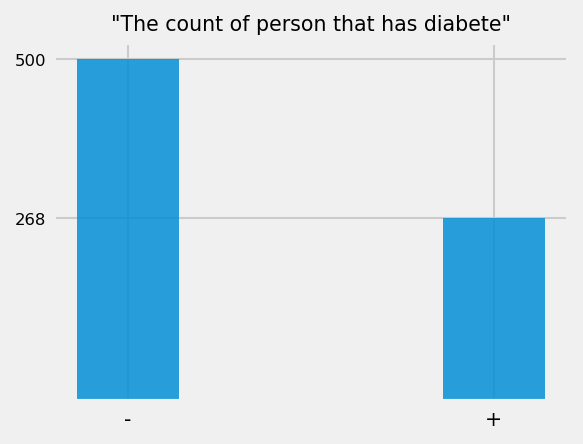

In [5]:
dataset_accuracy_train, dataset_accuracy_test= rbf(dataset, dataset)

balancing the dataset

In [6]:
class_0= dataset[dataset['Outcome'] == 0]
class_1= dataset[dataset['Outcome'] == 1]
sampled_class_0= class_0.sample(n= 200, random_state= 48)
sampled_class_1= class_1.sample(n= 200, random_state= 42)
balanced_sample= pd.concat([sampled_class_0, sampled_class_1])
balanced_sample.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age-name
665,1,112.0,80.0,45.0,132.0,34.8,0.217,24,0,young
29,5,117.0,92.0,30.0,121.0,34.1,0.337,38,0,mid
50,1,103.0,80.0,11.0,82.0,19.4,0.491,22,0,young
639,1,100.0,74.0,12.0,46.0,19.5,0.149,28,0,young
217,6,125.0,68.0,30.0,120.0,30.0,0.464,32,0,young


Accuracy of RBF SVM (C=1, gamma=0.001)(Train): 0.9025
Accuracy of RBF SVM (C=1, gamma=0.001)(Test): 0.8611


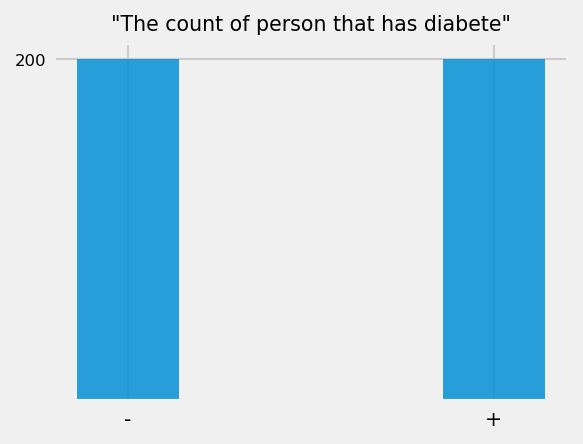

In [7]:
balanced_sample_accuracy_train, balanced_sample_accuracy_test= rbf(balanced_sample, dataset)

Resample

In [8]:
class_0= dataset[dataset['Outcome'] == 0]
class_1= dataset[dataset['Outcome'] == 1]
sampled_class_0= class_0.sample(n= 200, random_state= 48)
sampled_class_1= class_1.sample(n= 4, random_state= 42)
imbalanced_sample= pd.concat([sampled_class_0, sampled_class_1])
imbalanced_sample.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age-name
665,1,112.0,80.0,45.0,132.0,34.8,0.217,24,0,young
29,5,117.0,92.0,30.0,121.0,34.1,0.337,38,0,mid
50,1,103.0,80.0,11.0,82.0,19.4,0.491,22,0,young
639,1,100.0,74.0,12.0,46.0,19.5,0.149,28,0,young
217,6,125.0,68.0,30.0,120.0,30.0,0.464,32,0,young


Accuracy of RBF SVM (C=1, gamma=0.001)(Train): 0.9853
Accuracy of RBF SVM (C=1, gamma=0.001)(Test): 0.6528


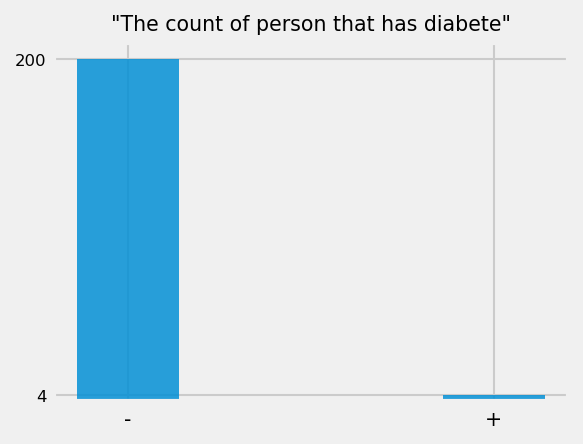

In [9]:
imbalanced_sample_accuracy_train, imbalanced_sample_accuracy_test= rbf(imbalanced_sample, dataset)

SMOTE

In [10]:
smote = SMOTE(k_neighbors= 3, random_state= 48)
x_smote, y_smote= smote.fit_resample(imbalanced_sample.drop(columns= ['Outcome', 'Age-name']), imbalanced_sample['Outcome'])
smote_oversample_dataset= x_smote.copy()
smote_oversample_dataset['Outcome']= y_smote
smote_oversample_dataset['Age-name']= np.nan
smote_oversample_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age-name
0,1,112.0,80.0,45.0,132.0,34.8,0.217,24,0,NaN
1,5,117.0,92.0,30.0,121.0,34.1,0.337,38,0,NaN
2,1,103.0,80.0,11.0,82.0,19.4,0.491,22,0,NaN
3,1,100.0,74.0,12.0,46.0,19.5,0.149,28,0,NaN
4,6,125.0,68.0,30.0,120.0,30.0,0.464,32,0,NaN


Accuracy of RBF SVM (C=1, gamma=0.001)(Train): 0.9950
Accuracy of RBF SVM (C=1, gamma=0.001)(Test): 0.7083


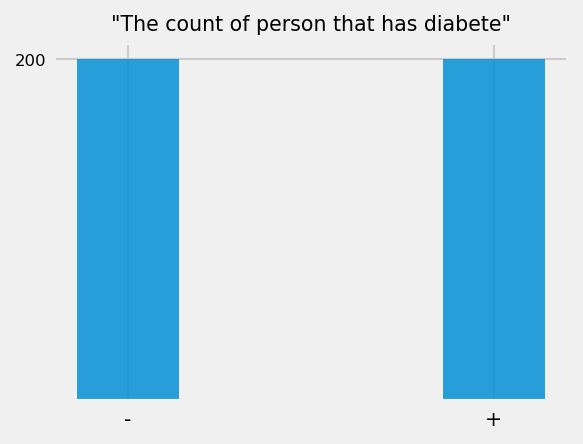

In [11]:
smote_oversample_dataset_accuracy_train, smote_oversample_dataset_accuracy_test= rbf(smote_oversample_dataset, dataset)

ADASYN

In [12]:
adasyn = ADASYN(n_neighbors= 3, random_state= 48)
x_adasyn, y_adasyn= adasyn.fit_resample(imbalanced_sample.drop(columns= ['Outcome', 'Age-name']), imbalanced_sample['Outcome'])
adasyn_oversample_dataset= x_smote.copy()
adasyn_oversample_dataset['Outcome']= y_smote
adasyn_oversample_dataset['Age-name']= np.nan
adasyn_oversample_dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Age-name
0,1,112.0,80.0,45.0,132.0,34.8,0.217,24,0,NaN
1,5,117.0,92.0,30.0,121.0,34.1,0.337,38,0,NaN
2,1,103.0,80.0,11.0,82.0,19.4,0.491,22,0,NaN
3,1,100.0,74.0,12.0,46.0,19.5,0.149,28,0,NaN
4,6,125.0,68.0,30.0,120.0,30.0,0.464,32,0,NaN


Accuracy of RBF SVM (C=1, gamma=0.001)(Train): 0.9950
Accuracy of RBF SVM (C=1, gamma=0.001)(Test): 0.7083


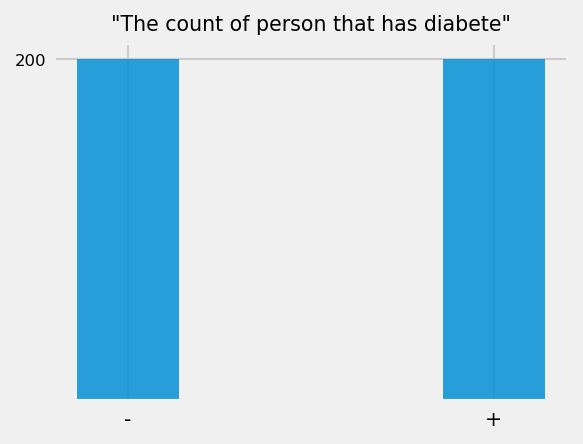

In [13]:
adasyn_oversample_dataset_accuracy_train, adasyn_oversample_dataset_accuracy_test= rbf(adasyn_oversample_dataset, dataset)

# Visualization

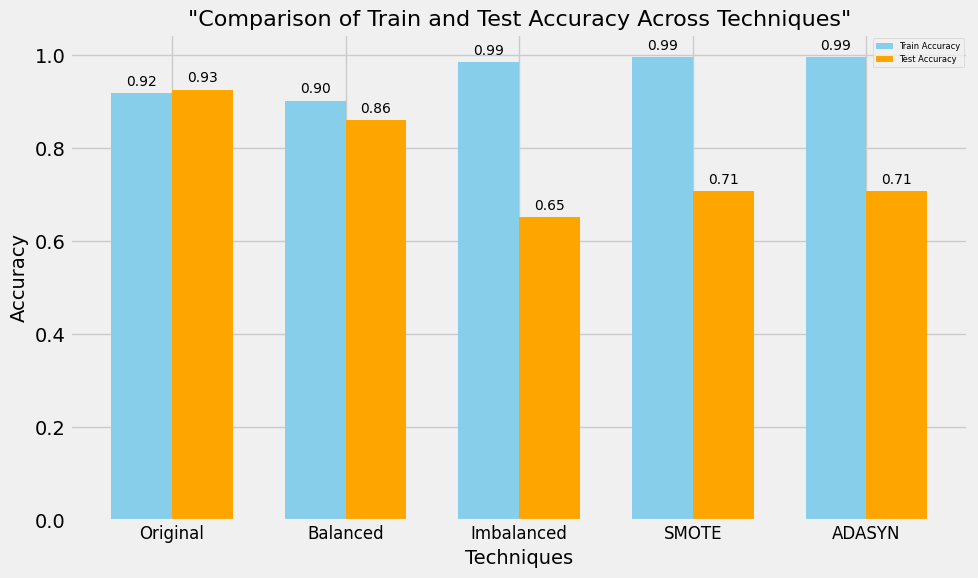

In [14]:
techniques= ['Original', 'Balanced', 'Imbalanced', 'SMOTE', 'ADASYN']
train_accuracy= [dataset_accuracy_train, balanced_sample_accuracy_train, imbalanced_sample_accuracy_train, smote_oversample_dataset_accuracy_train, adasyn_oversample_dataset_accuracy_train]
test_accuracy= [dataset_accuracy_test, balanced_sample_accuracy_test, imbalanced_sample_accuracy_test, smote_oversample_dataset_accuracy_test, adasyn_oversample_dataset_accuracy_test]
x= np.arange(len(techniques))
width= 0.35
fig, ax= plt.subplots(figsize=(10, 6))
bars1= ax.bar(x - width / 2, train_accuracy, width, label= 'Train Accuracy', color= 'skyblue')
bars2= ax.bar(x + width / 2, test_accuracy, width, label= 'Test Accuracy', color= 'orange')
ax.set_xlabel('Techniques', fontsize= 14)
ax.set_ylabel('Accuracy', fontsize= 14)
ax.set_title('"Comparison of Train and Test Accuracy Across Techniques"', fontsize= 16)
ax.set_xticks(x)
ax.set_xticklabels(techniques, fontsize= 12)
ax.legend(fontsize= 6)
def add_labels(bars):
    for bar in bars:
        height= bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy= (bar.get_x() + bar.get_width() / 2, height),
                    xytext= (0, 3),
                    textcoords= "offset points",
                    ha= 'center', va= 'bottom', fontsize= 10)
add_labels(bars1)
add_labels(bars2)
plt.tight_layout()
plt.show()